# 1D Poisson Equation

PDE:
$$\frac{d^2u}{dx^2}=-0.49\cdot sin(0.7x)-2.25\cdot cos(1.5x)$$

BC:
$$u(-10)=-sin(7)+cos(15)+1$$
$$u(10)=sin(7)+cos(15)-1$$

Solution:
$$u=sin(0.7x)+cos(1.5x)-0.1x$$

## 1. Import and setup random seeds

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def set_seeds(seeds):
    torch.manual_seed(seeds)
    torch.cuda.manual_seed(seeds)
    torch.backends.cudnn.deterministic = True

set_seeds(12)

## 2. Define MLP model

In [11]:
# input x, output u
class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        self.model = torch.nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

## 3. Define loss function

In [75]:
# mean square loss
mse_loss = nn.MSELoss()


# gradient
def gradient(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, only_inputs=True)[0]
    else:
        return gradient(gradient(u, x), x, order-1)


def loss_pde(model, n, device):

    x = torch.rand(n, 1, requires_grad=True, device=device) * 20.0 - 10.0
    cond = -0.49 * torch.sin(0.7 * x) - 2.25 * torch.cos(1.5 * x)
    u = model(x)

    return mse_loss(gradient(u, x, 2), cond)


def loss_u_left(model, device):

    x = torch.tensor([10.0], requires_grad=True, device=device)
    cond = - torch.sin(torch.tensor(7.0)) + torch.cos(torch.tensor(15.0)) + 1
    cond = cond.to(device)
    u = model(x)
    
    return mse_loss(u, cond)


def loss_u_right(model, device):

    x = torch.tensor([-10.0], requires_grad=True, device=device)
    cond = torch.sin(torch.tensor(7.0)) + torch.cos(torch.tensor(15.0)) - 1
    cond = cond.to(device)
    u = model(x)

    return mse_loss(u, cond)


## 4. Training

In [79]:
# set training parameters
num_epochs = 20000
device = "cuda:0" if torch.cuda.is_available() else "cpu"

n_pde = 1000 # PDE配点数

# record loss
loss_list = []
best_loss = 1.0E10

# training
model = MLP().to(device=device)
optimizer = torch.optim.Adam(params=model.parameters())

for epoch in range(num_epochs):
    optimizer.zero_grad()

    loss =  loss_pde(model, n_pde, device) + loss_u_left(model, device) + loss_u_right(model, device)
    loss.backward()
    
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: ", epoch, " loss: ", loss.item())

    # save model
    loss_list.append(loss.item()) # record loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "best.pth")


Epoch:  0  loss:  4.129096508026123
Epoch:  100  loss:  1.9190751314163208
Epoch:  200  loss:  1.8411049842834473
Epoch:  300  loss:  1.4508637189865112
Epoch:  400  loss:  1.4711920022964478
Epoch:  500  loss:  1.304465413093567
Epoch:  600  loss:  1.2424108982086182
Epoch:  700  loss:  1.0388721227645874
Epoch:  800  loss:  0.9108632206916809
Epoch:  900  loss:  0.9241265654563904
Epoch:  1000  loss:  0.6269263029098511
Epoch:  1100  loss:  0.6227759718894958
Epoch:  1200  loss:  0.5400856137275696
Epoch:  1300  loss:  0.5974774360656738
Epoch:  1400  loss:  0.6293730139732361
Epoch:  1500  loss:  0.48561087250709534
Epoch:  1600  loss:  0.40070855617523193
Epoch:  1700  loss:  0.24311399459838867
Epoch:  1800  loss:  0.18691299855709076
Epoch:  1900  loss:  0.17067182064056396
Epoch:  2000  loss:  0.14509734511375427
Epoch:  2100  loss:  0.1367899477481842
Epoch:  2200  loss:  0.12674665451049805
Epoch:  2300  loss:  0.09890439361333847
Epoch:  2400  loss:  0.09393138438463211
Epoch

## 5. Inference and visualization

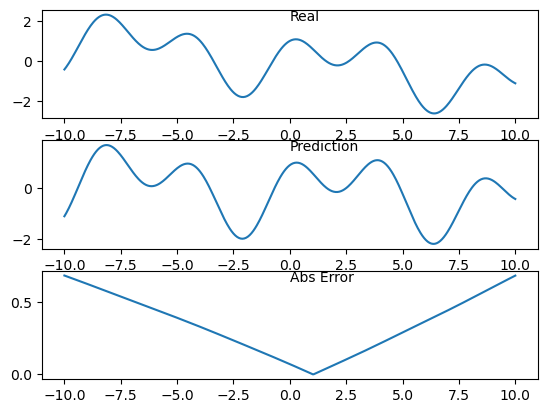

In [80]:
# mesh
n_mesh = 500 # 画图网格密度

# x for visualization
xv = torch.linspace(-10.0, 10.0, n_mesh).reshape(-1, 1)

# load model
model = MLP()
model.load_state_dict(torch.load("best.pth"))

# prediction
u_pred = model(xv)
u_real = torch.sin(0.7 * xv) + torch.cos(1.5 * xv) - 0.1 * xv
u_error = torch.abs(u_pred - u_real)

# plot
fig, axes = plt.subplots(3, 1)

axes[0].plot(xv.detach().numpy(), u_real.detach().numpy())
axes[0].text(0.5, 0.9, "Real", transform=axes[0].transAxes)

axes[1].plot(xv.detach().numpy(), u_pred.detach().numpy())
axes[1].text(0.5, 0.9, "Prediction", transform=axes[1].transAxes)

axes[2].plot(xv.detach().numpy(), u_error.detach().numpy())
axes[2].text(0.5, 0.9, "Abs Error", transform=axes[2].transAxes)

plt.show()


## References